In [ ]:
!kaggle datasets download -d nileshmalode1/samsum-dataset-text-summarization

Dataset URL: https://www.kaggle.com/datasets/nileshmalode1/samsum-dataset-text-summarization
License(s): unknown
 63% 5.00M/7.99M [00:00<00:00, 51.6MB/s]
100% 7.99M/7.99M [00:00<00:00, 52.3MB/s]


In [ ]:
!unzip samsum-dataset-text-summarization.zip

Archive:  samsum-dataset-text-summarization.zip
  inflating: samsum-test.csv         
  inflating: samsum-train.csv        
  inflating: samsum-validation.csv   
  inflating: samsum_dataset/dataset_dict.json  
  inflating: samsum_dataset/test/data-00000-of-00001.arrow  
  inflating: samsum_dataset/test/dataset_info.json  
  inflating: samsum_dataset/test/state.json  
  inflating: samsum_dataset/train/data-00000-of-00001.arrow  
  inflating: samsum_dataset/train/dataset_info.json  
  inflating: samsum_dataset/train/state.json  
  inflating: samsum_dataset/validation/data-00000-of-00001.arrow  
  inflating: samsum_dataset/validation/dataset_info.json  
  inflating: samsum_dataset/validation/state.json  


## Import Dependencies

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
from textblob import Word
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white",font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0","figure.facecolor":"#FFFAF0"})
sns.set_context("poster",font_scale = .7)

import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import math
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
import re,string,unicodedata
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from scipy.sparse import lil_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import pos_tag

from tensorflow.keras.regularizers import l2
import tensorflow
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import SimpleRNN,LSTM,GRU, Embedding, Dense, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, Attention, Input, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

## Fetch the Dataset


In [ ]:
train_df = pd.read_csv('samsum-train.csv')
test_df = pd.read_csv('samsum-test.csv')

In [ ]:
train_df.sample(5)

,id,dialogue,summary
8915,13730861-1,"George: Goodness, finally home!\r\nGeorge: the...",George is home after a long journey. He and Su...
1614,13819605,"Joanna: Feel free to come over, I have made a ...",Joanna's parents came over this weekend and le...
633,13716131,"Erica: Guys, I'm trying MarieKondo now so if y...",Erica needs free jars to try MarieKondo method...
13946,13681657,Jess: need a new pillow\r\nJess: the one I hav...,Jess and Sunny are going shopping for a new pi...
11602,13865029,Love: The party was awesome!\nJesus: Oh yes \n...,Love and Jesus were at the awesome party. Arms...


In [ ]:
test_df.sample(5)

,id,dialogue,summary
448,13821588,Reeve: any plans for winter break?\r\nWinslow:...,Reeve has no plans for the winter break. Booke...
648,13865481,May: Just received a text from Harry he'll be ...,Henry and Peter will be late for a birthday pa...
509,13729534,Marco: hi there! is this yours?\r\nMarco: <fil...,Sandra bought a present for Milla right before...
73,13681586,"Mia: babe, do you mind if i go out after work ...",Mia is going out after work tonight with her f...
574,13864673,Damian: guys did u watch Chelsea game\nJacob: ...,Chelsea won a game with Huddersfield this afte...


## Understanding the Data

In [ ]:
print("train_df shape: ",train_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (14732, 3)
test_df shape:  (819, 3)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


In [ ]:
print("Duplicates in Dataset: ",train_df.duplicated().sum())

Duplicates in Dataset:  0


In [ ]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
id,0,0.00
dialogue,1,0.01
summary,0,0.00


In [ ]:
round(train_df.describe().T,2)

,count,unique,top,freq
id,14732,14732,13729017,1
dialogue,14731,14264,"Jimmy: Hey, guess what? My car's completely ka...",4
summary,14732,14730,Seth's pet Oreo that he got when he was 10 is ...,2


## Data Preprocessing

In [ ]:
col = 'id'
train_df.drop(col,axis = 1,inplace = True)
test_df.drop(col,axis = 1,inplace = True)

In [ ]:
train_df.dropna(inplace = True)

In [ ]:
train_df['dialogue'] = train_df['dialogue'].str.lower()
train_df['summary'] = train_df['summary'].str.lower()
test_df['dialogue'] = test_df['dialogue'].str.lower()
test_df['summary'] = test_df['summary'].str.lower()

In [ ]:
import re
def remove_html_tags(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text


In [ ]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_html_tags)
train_df['summary'] = train_df['summary'].apply(remove_html_tags)
test_df['dialogue'] = test_df['dialogue'].apply(remove_html_tags)
test_df['summary'] = test_df['summary'].apply(remove_html_tags)

In [ ]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

train_df['dialogue'] = train_df['dialogue'].apply(remove_url)
train_df['summary'] = train_df['summary'].apply(remove_url)
test_df['dialogue'] = test_df['dialogue'].apply(remove_url)
test_df['summary'] = test_df['summary'].apply(remove_url)

In [ ]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}

In [ ]:
def chat_conversion(text):
    new_text=[]
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [ ]:
train_df['dialogue'] = train_df['dialogue'].apply(chat_conversion)
train_df['summary'] = train_df['summary'].apply(chat_conversion)
test_df['dialogue'] = test_df['dialogue'].apply(chat_conversion)
test_df['summary'] = test_df['summary'].apply(chat_conversion)

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
train_df['dialogue'] = train_df['dialogue'].apply(remove_emoji)
train_df['summary'] = train_df['summary'].apply(remove_emoji)
test_df['dialogue'] = test_df['dialogue'].apply(remove_emoji)
test_df['summary'] = test_df['summary'].apply(remove_emoji)

In [ ]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

train_df['dialogue'] = train_df['dialogue'].apply(expand_contractions)
train_df['summary'] = train_df['summary'].apply(expand_contractions)
test_df['dialogue'] = test_df['dialogue'].apply(expand_contractions)
test_df['summary'] = test_df['summary'].apply(expand_contractions)

In [ ]:
train_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['summary']]
test_df['summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['summary']]

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(train_df['dialogue']+train_df['summary'])

In [ ]:
len(tok.word_index)

33259

In [ ]:
tok.document_count

14731

In [ ]:
train_df['dialogue'] = tok.texts_to_sequences(train_df['dialogue'])
train_df['summary'] = tok.texts_to_sequences(train_df['summary'])

test_df['dialogue'] = tok.texts_to_sequences(test_df['dialogue'])
test_df['summary'] = tok.texts_to_sequences(test_df['summary'])

In [ ]:
train_df

,dialogue,summary
0,"[423, 1, 3359, 1528, 15, 2, 71, 52, 584, 70, 4...","[16, 423, 3359, 1528, 6, 12, 211, 584, 52, 98,..."
1,"[318, 144, 18, 2, 5396, 11, 10, 39, 2944, 604,...","[16, 318, 6, 1588, 18, 5396, 11, 11934, 10, 39..."
2,"[225, 116, 26, 7, 60, 356, 217, 1440, 3, 24, 8...","[16, 356, 235, 174, 4, 16211, 13671, 1959, 118..."
3,"[1001, 410, 1, 61, 1, 21, 10, 21537, 29, 831, ...","[16, 1001, 556, 38, 7, 10, 132, 29, 831, 410, ..."
4,"[192, 113, 9658, 491, 167, 109, 192, 1, 15, 8,...","[16, 192, 7, 2350, 110, 38, 9658, 491, 2300, 3..."
...,...,...
14727,"[4686, 2, 18, 25, 20, 141, 2, 235, 32, 845, 13...","[16, 4686, 7, 512, 3, 64, 1386, 3, 1281, 76, 3..."
14728,"[1076, 137, 1076, 137, 1076, 113, 882, 50, 18,...","[16, 1076, 7, 27, 96, 33, 765, 323, 341, 6, 32..."
14729,"[112, 432, 146, 52, 217, 527, 2850, 12, 5972, ...","[16, 2850, 7, 46, 3, 5972, 8896, 177, 1983, 6,..."
14730,"[597, 631, 2969, 50, 18, 2, 214, 597, 4, 656, ...","[16, 2969, 101, 8, 129, 9, 3, 4, 656, 29, 4, 3..."


In [ ]:
def calculate_max_sequence_length(train_summary,train_dialogue,test_summary,test_dialogue):
    max_length_1 = max(max(len(seq) for seq in train_dialogue), max(len(seq) for seq in train_summary))
    max_length_2 = max(max(len(seq) for seq in test_dialogue), max(len(seq) for seq in test_summary))
    max_length_combined = max(max_length_1,max_length_2)
    return max_length_combined

max_length_combined = calculate_max_sequence_length(train_df['dialogue'],train_df['summary'],test_df['dialogue'],test_df['summary'])
max_length_combined

819

In [ ]:
for num in train_df['dialogue'][0]:
    print(num, end=' ')

423 1 3359 1528 15 2 71 52 584 70 423 54 211 2 98 

In [ ]:
for num in train_df['dialogue'][0]:
    word = tok.index_word.get(num, 'UNK')
    print(word, end=' ')

amanda i baked cookies do you want some jerry sure amanda ill bring you tomorrow 

In [ ]:
for num in train_df['summary'][0]:
    word = tok.index_word.get(num)
    print(word,end = " ")

start amanda baked cookies and will bring jerry some tomorrow end 

In [ ]:
x_train = pad_sequences(train_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_train = pad_sequences(train_df['summary'],maxlen = max_length_combined,padding = 'post')
x_test = pad_sequences(test_df['dialogue'],maxlen = max_length_combined,padding = 'post')
y_test = pad_sequences(test_df['summary'],maxlen = max_length_combined,padding = 'post')

In [ ]:
x_train

array([[ 423,    1, 3359, ...,    0,    0,    0],
       [ 318,  144,   18, ...,    0,    0,    0],
       [ 225,  116,   26, ...,    0,    0,    0],
       ...,
       [ 112,  432,  146, ...,    0,    0,    0],
       [ 597,  631, 2969, ...,    0,    0,    0],
       [1586,   18,    2, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_train

array([[  16,  423, 3359, ...,    0,    0,    0],
       [  16,  318,    6, ...,    0,    0,    0],
       [  16,  356,  235, ...,    0,    0,    0],
       ...,
       [  16, 2850,    7, ...,    0,    0,    0],
       [  16, 2969,  101, ...,    0,    0,    0],
       [  16, 1586,    6, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (14731, 819)
Shape of x_test: (819, 819)
Shape of y_train: (14731, 819)
Shape of y_test: (819, 819)


## Model Building

In [ ]:
max_length_input = x_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size = len(tok.word_index) + 1
output_vocab_size = len(tok.word_index) + 1

# Encoder model
encoder_inputs = Input(shape=(max_length_input,))
encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=260)(encoder_inputs)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)
encoder_lstm = LSTM(64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder model
decoder_inputs = Input(shape=(max_length_output,))
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=260)(decoder_inputs)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = Attention()([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder outputs
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# Dense Layer for output prediction
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 819)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 819)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 819, 260)       │      8,647,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 819, 260)       │      8,647,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding[0][0]        │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 819, 64),      │         83,200 │ embedding_1[0][0],     │
│                           │ (None, 64), (None,     │                │ lstm_1[0][1],          │
│                           │ 64)]                   │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 819, 64)        │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 819, 128)       │              0 │ lstm_3[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 819, 33260)     │      4,290,540 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,752,140 (82.98 MB)

 Trainable params: 21,752,140 (82.98 MB)

 Non-trainable params: 0 (0.00 B)

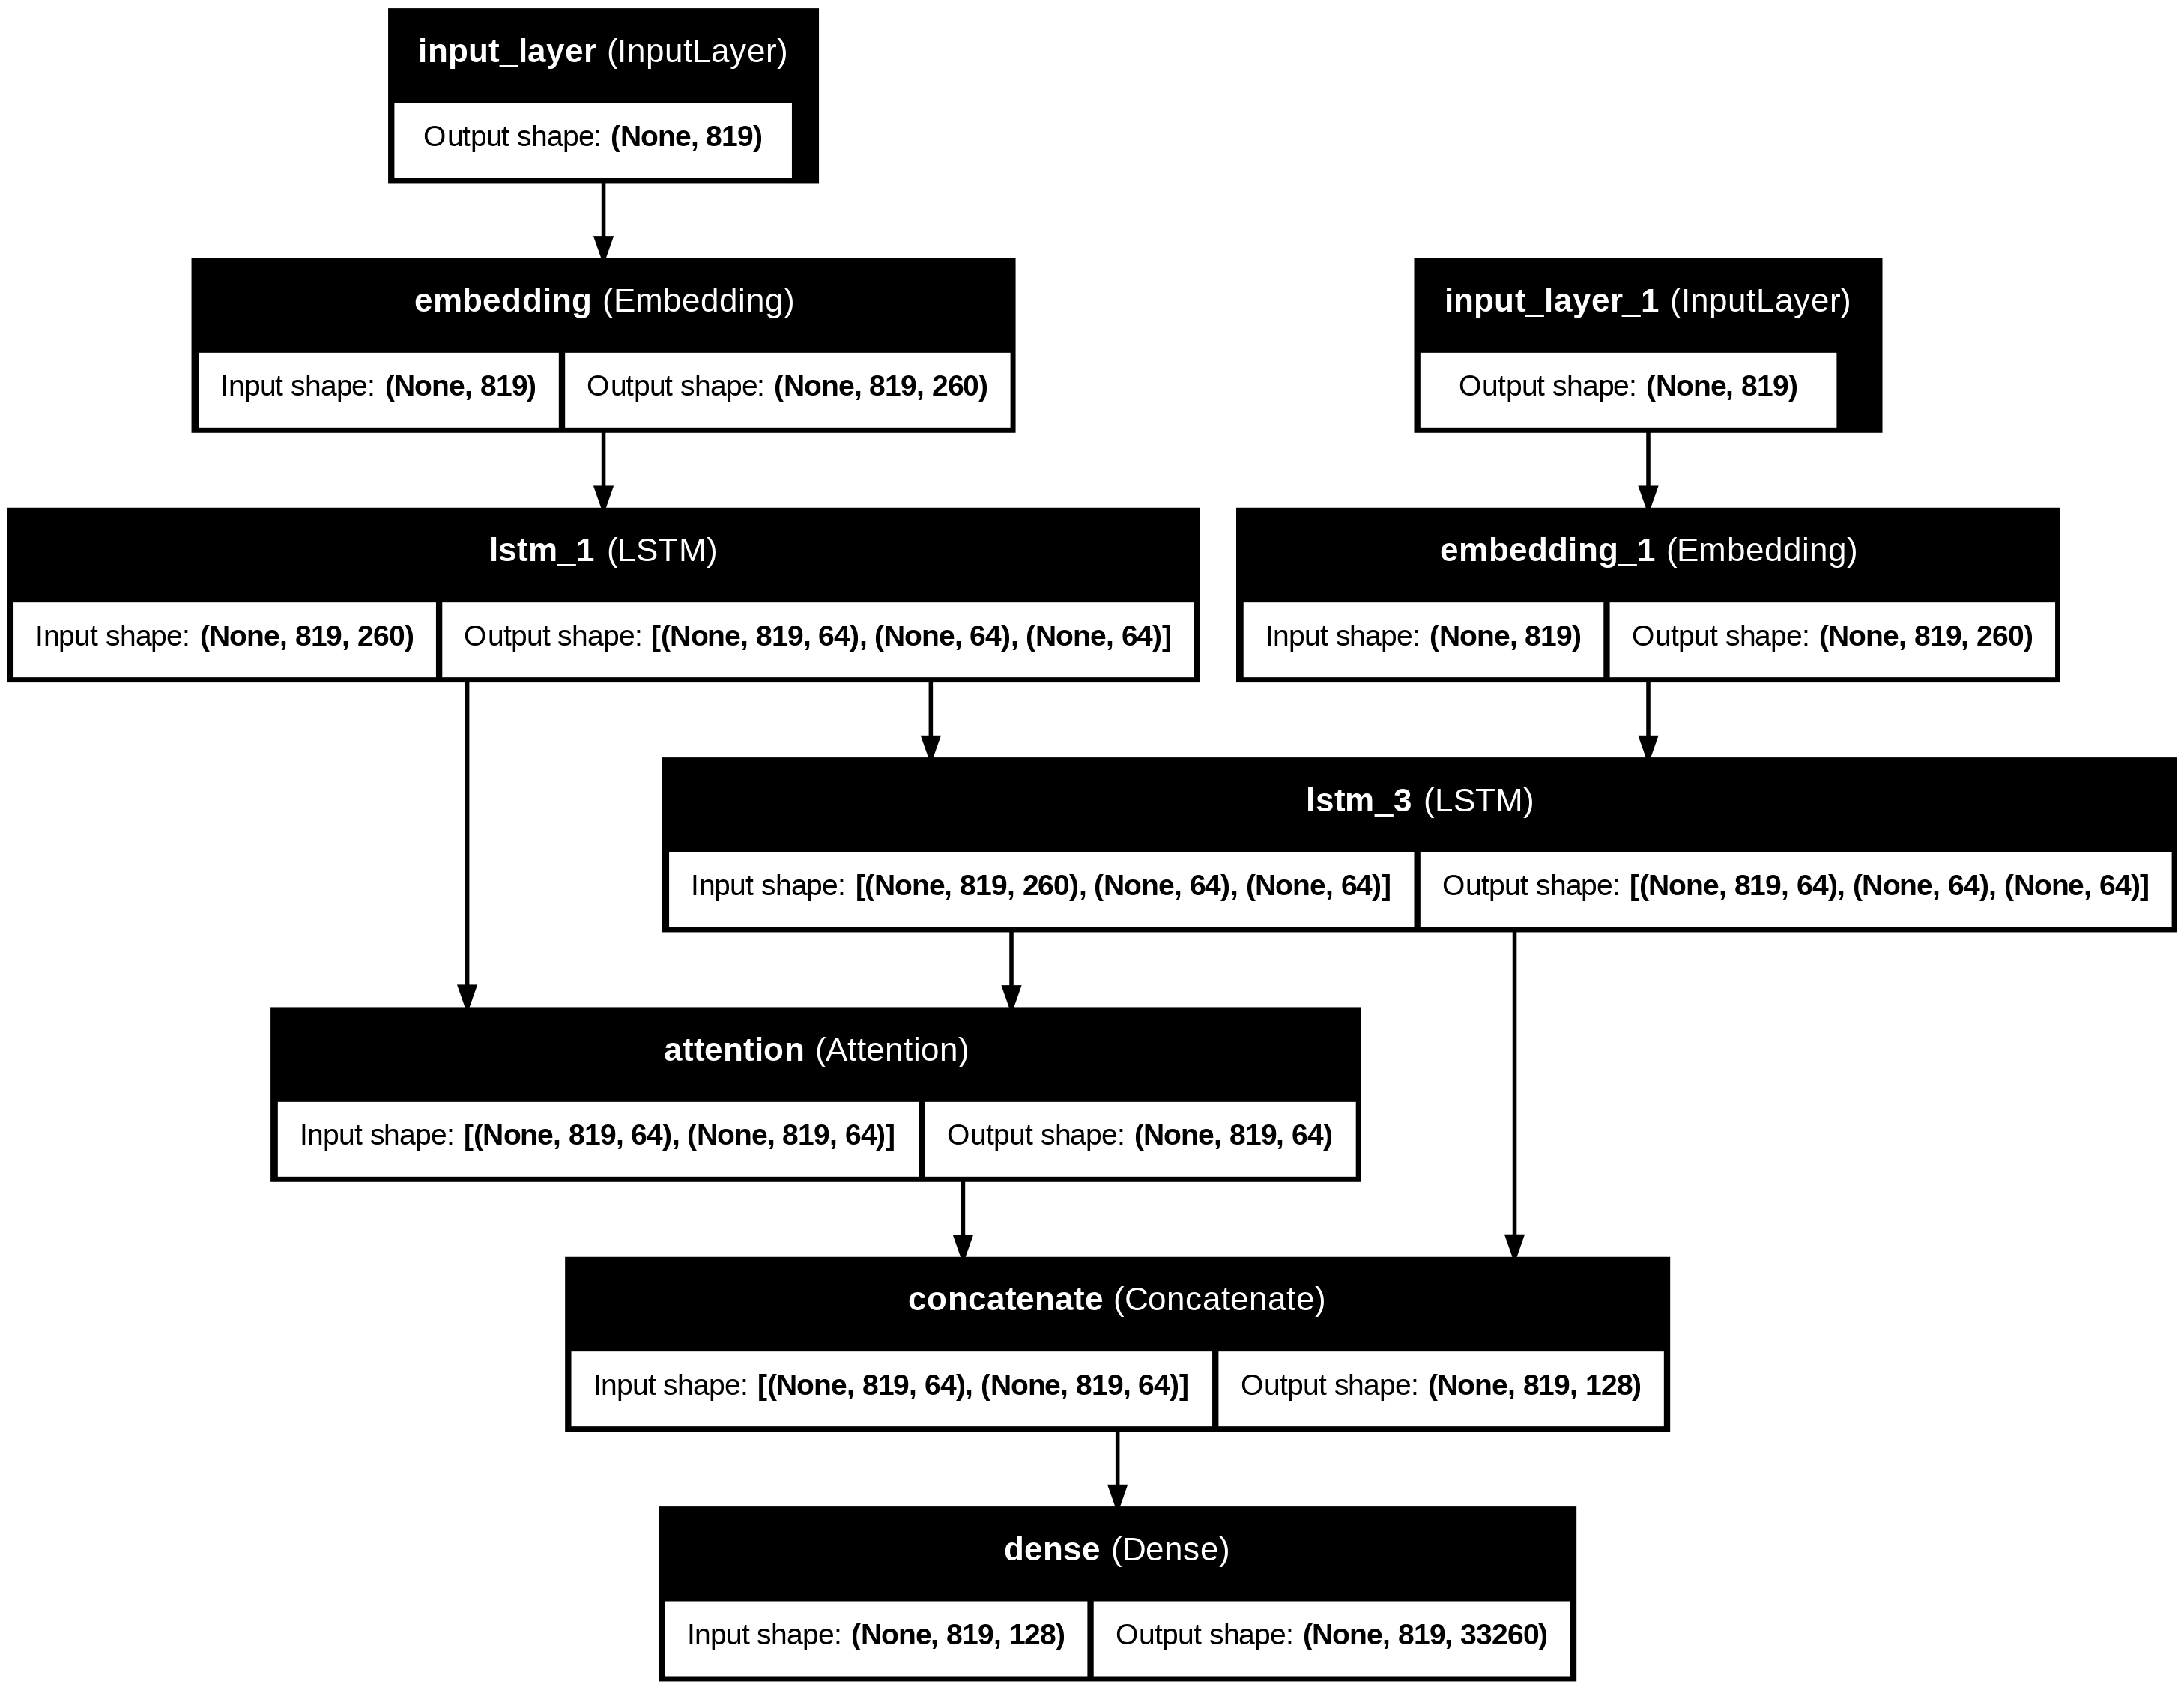

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)

history = model.fit(
    x=[x_train, y_train],
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=([x_test, y_test], y_test),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 344s 368ms/step - accuracy: 0.9674 - loss: 1.2566 - val_accuracy: 0.9856 - val_loss: 0.1130
Epoch 2/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 346s 376ms/step - accuracy: 0.9866 - loss: 0.1060 - val_accuracy: 0.9912 - val_loss: 0.0714
Epoch 3/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 336s 365ms/step - accuracy: 0.9915 - loss: 0.0702 - val_accuracy: 0.9938 - val_loss: 0.0523
Epoch 4/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 389s 372ms/step - accuracy: 0.9939 - loss: 0.0524 - val_accuracy: 0.9954 - val_loss: 0.0401
Epoch 5/5
921/921 ━━━━━━━━━━━━━━━━━━━━ 384s 375ms/step - accuracy: 0.9953 - loss: 0.0405 - val_accuracy: 0.9964 - val_loss: 0.0319


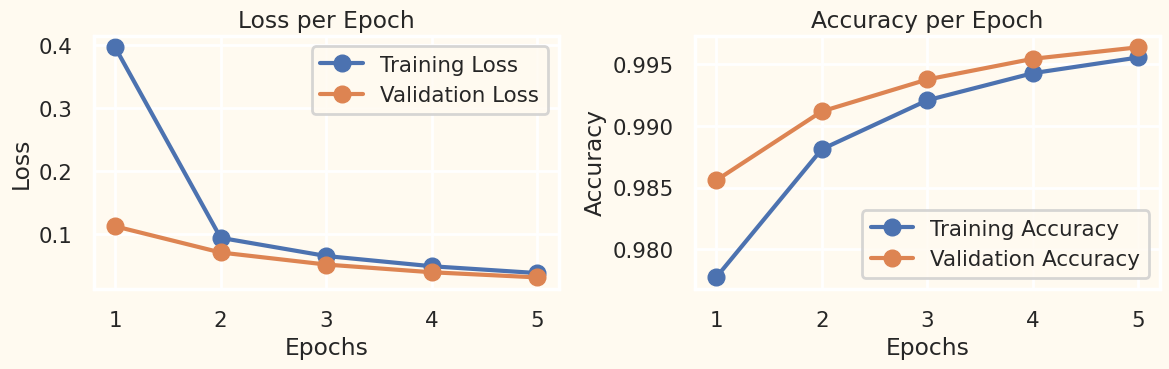

In [ ]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Reverse token dictionary for summary (assuming you have a tokenizer `tok` for summary)
rev_tok_summary = {idx: word for word, idx in tok.word_index.items()}
rev_tok_dialogue = {idx: word for word, idx in tok.word_index.items()}  # If the dialogue uses the same tokenizer

# Define the batch size
batch_size = 10

# Initialize lists to store predictions and references
predicted_summaries = []
references = []

# Predict on x_test data in batches
for start in range(0, len(x_test), batch_size):
    end = min(start + batch_size, len(x_test))
    x_batch = x_test[start:end]
    y_batch = y_test[start:end]  # Use the corresponding y_test for padding purposes

    # Predict on the batch
    predictions = model.predict([x_batch, y_batch], batch_size=batch_size)

    # Convert predicted tokens to sentences (predicted summaries)
    predicted_tokens_np = np.argmax(predictions, axis=-1)

    for sample in predicted_tokens_np:
        # Convert the predicted tokens into the corresponding words for the summary
        predicted_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        predicted_summaries.append(predicted_sentence)

    # Extract the true (actual) summaries for the BLEU score references
    for i in range(len(y_batch)):
        true_summary_sentence = ' '.join([rev_tok_summary.get(token, '<unknown>') for token in y_batch[i] if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])
        references.append([true_summary_sentence.split()])  # BLEU expects list of references for each hypothesis

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
bleu_score = corpus_bleu(references, [pred.split() for pred in predicted_summaries])
print(f'BLEU score: {bleu_score:.4f}')

BLEU score: 0.6835


## Predicitons

In [ ]:
y_test[:5]

array([[  16,  380,  287, ...,    0,    0,    0],
       [  16,  479,    6, ...,    0,    0,    0],
       [  16, 1165,   81, ...,    0,    0,    0],
       [  16,  252,   12, ...,    0,    0,    0],
       [  16,  196,    7, ...,    0,    0,    0]], dtype=int32)

In [ ]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Reverse token dictionaries
rev_tok = {idx: word for word, idx in tok.word_index.items()}

# Select a subset of test data
num_samples = 5
x_test_subset = x_test[:num_samples]
y_test_padded_subset = y_test[:num_samples]

# Predict
predictions = model.predict([x_test_subset, y_test_padded_subset], batch_size=16)
print('Shape of predictions:', predictions.shape)

# Convert predictions to token indices
predicted_tokens_np = np.argmax(predictions, axis=-1)
print('Shape of predicted_tokens:', predicted_tokens_np.shape)

# Map indices to tokens and remove 'start' and 'end' tokens from predicted summary
predicted_sentences = []
for sample in predicted_tokens_np:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    predicted_sentences.append(sentence)

# Reverse token dictionary for the dialogue (assuming you have `tok_english` for dialogue tokens)
rev_tok_english = {idx: word for word, idx in tok.word_index.items()}

# Map the dialogue input to sentences
english_sentences = []
for sample in x_test_subset:
    sentence = ' '.join([rev_tok_english.get(token, '<unknown>') for token in sample if token != 0])  # Exclude padding token
    english_sentences.append(sentence)

# Map actual summaries from y_test to sentences
actual_summaries = []
for sample in y_test_padded_subset:
    sentence = ' '.join([rev_tok.get(token, '<unknown>') for token in sample if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])  # Exclude padding, 'start', and 'end' tokens
    actual_summaries.append(sentence)

# Print the dialogue, predicted summary, and actual summary
for idx, (eng_sentence, pred_summary, actual_summary) in enumerate(zip(english_sentences, predicted_sentences, actual_summaries)):
    print(f'Dialogue {idx + 1}: {eng_sentence}')
    print(f'Predicted summary {idx + 1}: {pred_summary}')
    print(f'Actual summary {idx + 1}: {actual_summary}\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Shape of predictions: (5, 819, 33260)
Shape of predicted_tokens: (5, 819)
Dialogue 1: hannah hey do you have bettys number amanda let me check hannah filegif amanda sorry cannot find it amanda ask larry amanda he called her last tears in my eyes we were at the park together hannah i do not know him well hannah filegif amanda do not be shy hes very nice hannah if you say so hannah id rather you texted him amanda just text him hannah urgh alright hannah bye amanda bye bye
Predicted summary 1: hannah needs lonely number but amanda does not have it she needs to contact larry
Actual summary 1: hannah needs bettys number but amanda does not have it she needs to contact larry

Dialogue 2: eric machine rob that is so great eric i know and shows how americans see russian rob and its really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his only standup rob i do not know ill check eric sure r

## Save the Model

In [ ]:
model.save('encoder_decoder_model.h5')
print('Model saved succesfully!!')

Model saved succesfully!!


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def summarize_user_input(user_input, tok, model, max_length_combined):
    input_text = user_input.lower()
    input_text = remove_html_tags(input_text)
    input_text = remove_url(input_text)
    input_text = remove_emoji(input_text)
    input_text = expand_contractions(input_text)

    input_seq = tok.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_length_combined, padding='post')
    target_seq = np.zeros_like(input_seq)  # Initialize the target sequence as zeros

    print("Input Sequence:", input_seq)
    print("Target Sequence:", target_seq)

    prediction = model.predict([input_seq, target_seq], batch_size=1)
    print("Raw Prediction Shape:", prediction.shape)
    print("Raw Prediction:", prediction)

    # Get the token with the highest probability for each position
    predicted_tokens = np.argmax(prediction, axis=-1)
    print("Predicted Tokens:", predicted_tokens)

    rev_tok = {idx: word for word, idx in tok.word_index.items()}

    summary_text = ' '.join([rev_tok.get(token, '<unknown>') for token in predicted_tokens[0]
                            if token != 0 and token not in [tok.word_index.get('start'), tok.word_index.get('end')]])

    return summary_text

user_input = "Artificial intelligence (AI) is intelligence demonstrated by machines, unlike the natural intelligence displayed by humans and animals. Leading AI textbooks define the field as the study of 'intelligent agents': any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals. Colloquially, the term 'artificial intelligence' is often used to describe machines (or computers) that mimic 'cognitive' functions that humans associate with the human mind, such as 'learning' and 'problem-solving."
summary = summarize_user_input(user_input, tok, model, max_length_combined)
print("Summarized Content: ", summary)

Input Sequence: [[ 8570 23664  5885     7 23664 25059   118  5493  4990     4  2499 23664
  13691   118  6250     6  2665  7173  5885 20929 12965     4  2333    57
      4   937    19  9073 28970   124  5797    14 22422    31  4907     6
   1117  8019    14 17980    31   873    19 11555 32058    31  4779     4
   2441  8570 23664     7  1159   488     3  4481  5493    82  9518    14
  28379 20420  8813    14  6250    29     4  3244   398   358    57  2068
      6     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0   